### Building CHatbots with multiple tools 

#### AIM
Create a chatbot with tool capabilities from arxiv , wikipedia and some function

In [30]:
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper , ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import ToolNode , tools_condition
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image , display
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage , AnyMessage
from pprint import PrettyPrinter
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [8]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2 , doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [15]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1 , doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [16]:
wiki.invoke("What is Machine Learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [19]:
#Tavily Search Tool
tavily = TavilySearchResults()


C:\Users\User\AppData\Local\Temp\ipykernel_12092\3074595494.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [20]:
tavily.invoke("Provide me the recent job market news in United States")

[{'title': "Job Market's Effect on the Economy | U.S. Bank",
  'url': 'https://www.usbank.com/investing/financial-perspectives/market-news/effect-of-job-market-on-the-economy.html',
  'content': 'Job openings data suggest the labor market is moving toward a more restrained setting. As of December 2025, job openings totaled 6.5 million while unemployed persons were 7.5 million, a gap of nearly one million—a notable shift from the earlier “worker shortage” era, in the wake of the recent pandemic. 2 The same report shows hires and total separations were roughly 5.3 million each, which is consistent with a “freeze” dynamic in the labor market rather than expansion. 2 [...] That stronger headline arrives after a softer finish to last year. In December, the U.S. economy added 48,000 jobs, and the unemployment rate sat at 4.4%, reflecting slower momentum than earlier in 2025. 1 January’s improvement helps reinforce that the labor market is still moving forward, even if the pace remains uneven

In [21]:
tools = [arxiv,wiki,tavily]

In [26]:
#Initialise my LLM Model
llm = ChatGroq(model="qwen/qwen3-32b" , reasoning_format="hidden")
llm_with_tools = llm.bind_tools(tools)

In [27]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI news?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '89jgkk71t', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 265, 'prompt_tokens': 400, 'total_tokens': 665, 'completion_time': 0.836240188, 'completion_tokens_details': {'reasoning_tokens': 236}, 'prompt_time': 0.01965805, 'prompt_tokens_details': None, 'queue_time': 0.038087667, 'total_time': 0.855898238}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_78ac7f3229', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c6dd3-3670-7952-b0fb-e452b215f8ef-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': '89jgkk71t', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 400, 'output_tokens': 265, 'total_tokens': 665, 'output_token_details': {'reasoning': 2

In [31]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [32]:
def tool_calling_llm(state:State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages":response}

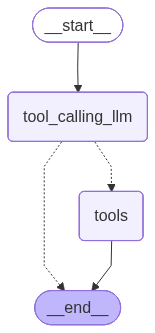

In [33]:
builder = StateGraph(State)

builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START , "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content=f"What is Machine Learning?")})
print(messages["messages"][-1].content)

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi


### ReAct Agent

In [39]:
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ReAct Agent"

In [42]:
def multiply(a:int , b:int) -> int:
    """Multiply a and b
    Args:
        a:first int
        b:second int
    
    """
    return a*b


def add(a:int , b:int) -> int:
    """Add a and b
    Args:
        a:first int
        b:second int
    
    """
    return a+b



def divide(a:int , b:int) -> int:
    """Divide a and b
    Args:
        a:first int
        b:second int
    
    """
    return a/b


tools_react = [arxiv,wiki,add,multiply,divide]

In [43]:
llm_with_tools_react = llm.bind_tools(tools_react)

In [44]:
llm_with_tools_react.invoke("What is 2 multiply 2?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4dxteyejn', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 248, 'prompt_tokens': 544, 'total_tokens': 792, 'completion_time': 1.066301912, 'completion_tokens_details': {'reasoning_tokens': 220}, 'prompt_time': 0.024275685, 'prompt_tokens_details': None, 'queue_time': 0.265141901, 'total_time': 1.090577597}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c7176-9220-7a21-89c9-673f656290c8-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 2}, 'id': '4dxteyejn', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 544, 'output_tokens': 248, 'total_tokens': 792, 'output_token_details': {'reasoning': 220}})

In [45]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

In [46]:
def tool_calling_llm_react(state:State):
    response = llm_with_tools_react.invoke(state["messages"])
    return {"messages":response}

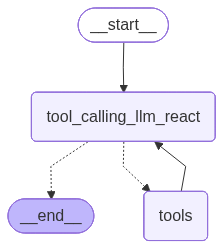

In [49]:
builder_react = StateGraph(State)
builder_react.add_node("tool_calling_llm_react",tool_calling_llm_react)
builder_react.add_node("tools",ToolNode(tools_react))

builder_react.add_edge(START , "tool_calling_llm_react")
builder_react.add_conditional_edges(
    "tool_calling_llm_react",
    tools_condition
)

builder_react.add_edge("tools" , "tool_calling_llm_react")


graph_react = builder_react.compile()
display(Image(graph_react.get_graph().draw_mermaid_png()))

In [50]:
messages = graph_react.invoke({"messages":HumanMessage(content=f"What is Machine Lerning ? and then tell me what is 2 plus 2")})
print(messages["messages"][-1].content)

Machine Learning is a field of study within artificial intelligence that focuses on developing algorithms capable of learning patterns from data and making decisions or predictions without being explicitly programmed for specific tasks. Key aspects include:
- Learning from data to generalize to unseen scenarios
- Using statistical methods to improve performance over time
- Subfields like deep learning (neural networks) that have advanced capabilities in areas like image recognition and natural language processing.

**2 + 2 = 4**.


### Agent with Memory in Langgraph 

In [51]:
def tool_calling_llm_react(state:State):
    response = llm_with_tools_react.invoke(state["messages"])
    return {"messages":response}

builder_react = StateGraph(State)
builder_react.add_node("tool_calling_llm_react",tool_calling_llm_react)
builder_react.add_node("tools",ToolNode(tools_react))

builder_react.add_edge(START , "tool_calling_llm_react")
builder_react.add_conditional_edges(
    "tool_calling_llm_react",
    tools_condition
)

builder_react.add_edge("tools" , "tool_calling_llm_react")




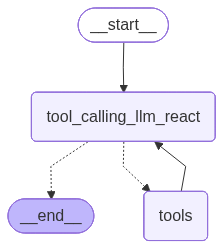

In [52]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph_with_memory = builder_react.compile(checkpointer=memory)
display(Image(graph_react.get_graph().draw_mermaid_png()))

In [53]:
#Specify a thread 
config = {"configurable":{"thread_id":"1"}}

messages = [HumanMessage(content="Add 3 and 4")]
messages = graph_with_memory.invoke({"messages":messages} , config=config)
print(messages["messages"][-1])

content='The sum of 3 and 4 is **7**.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 95, 'prompt_tokens': 585, 'total_tokens': 680, 'completion_time': 0.157581198, 'completion_tokens_details': {'reasoning_tokens': 78}, 'prompt_time': 0.021351165, 'prompt_tokens_details': {'cached_tokens': 512}, 'queue_time': 0.032511739, 'total_time': 0.178932363}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_78ac7f3229', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019c72bb-87a1-7340-8135-81d8b12f756e-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 585, 'output_tokens': 95, 'total_tokens': 680, 'input_token_details': {'cache_read': 512}, 'output_token_details': {'reasoning': 78}}


In [54]:
messages = [HumanMessage(content="Add that number with 4")]
messages = graph_with_memory.invoke({"messages":messages} , config=config)
print(messages["messages"][-1])

content='The sum of 7 and 4 is **11**.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 141, 'prompt_tokens': 658, 'total_tokens': 799, 'completion_time': 0.255589458, 'completion_tokens_details': {'reasoning_tokens': 123}, 'prompt_time': 0.030604745, 'prompt_tokens_details': None, 'queue_time': 0.011406496, 'total_time': 0.286194203}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_78ac7f3229', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'} id='lc_run--019c72bc-06c1-70b0-bb4c-585ea99c91e8-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 658, 'output_tokens': 141, 'total_tokens': 799, 'output_token_details': {'reasoning': 123}}


In [55]:
llm = ChatGroq(model="qwen/qwen3-32b" , reasoning_format="hidden")

In [56]:
#Stream 
def superbot(state:State):
    response = llm.invoke(state["messages"])
    return {"messages": response}

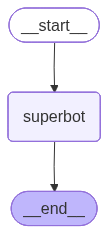

In [57]:
graph = StateGraph(State)

graph.add_node("superbot",superbot)
graph.add_edge(START , "superbot")
graph.add_edge("superbot" , END)


graph_stream = graph.compile(checkpointer=memory)

display(Image(graph_stream.get_graph().draw_mermaid_png()))

In [58]:
config = {"configurable": {"thread_id":"2"}}
graph_stream.invoke({"messages":"Hi my name is neel and I like to play cricket"} , config= config)

{'messages': [HumanMessage(content='Hi my name is neel and I like to play cricket', additional_kwargs={}, response_metadata={}, id='af474dbe-fd79-480f-bc5a-70aa0bbcae33'),
  AIMessage(content='Hello Neel! Nice to meet you. Cricket is an amazing sport—I’d love to hear more about what you enjoy most about playing it! Do you prefer batting, bowling, or fielding? Also, do you play regularly with friends or on a team, and who’s your favorite player to watch? 🏏', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 177, 'prompt_tokens': 20, 'total_tokens': 197, 'completion_time': 0.431483875, 'completion_tokens_details': {'reasoning_tokens': 108}, 'prompt_time': 0.000617205, 'prompt_tokens_details': None, 'queue_time': 0.006526532, 'total_time': 0.43210108}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_78ac7f3229', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c72d6-16fa-7613-9aed-858da9

In [59]:
config = {"configurable": {"thread_id":"3"}}

for chunk in graph_stream.stream({"messages":"Hi my name is neel and I like to play cricket"} , config= config , stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': AIMessage(content="Hi Neel! 🏏 That's awesome—cricket is such an exciting game! Do you play any particular position, or are you more into watching matches? Also, do you have a favorite team or player? I'd love to hear more about what you enjoy about the game!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 20, 'total_tokens': 258, 'completion_time': 0.610266871, 'completion_tokens_details': {'reasoning_tokens': 175}, 'prompt_time': 0.001439538, 'prompt_tokens_details': None, 'queue_time': 0.084093135, 'total_time': 0.611706409}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_d58dbe76cd', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c72d8-8c93-7590-9093-7cbf7365abc0-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 20, 'output_tokens': 238, 'total_tokens': 258, 'output_token_details': {'reasoning': 175}})}}

In [60]:
for chunk in graph_stream.stream({"messages":"Hi my name is neel and I like to play cricket"} , config= config , stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi my name is neel and I like to play cricket', additional_kwargs={}, response_metadata={}, id='c035ceda-e017-4cce-a302-3c6e47f52f9e'), AIMessage(content="Hi Neel! 🏏 That's awesome—cricket is such an exciting game! Do you play any particular position, or are you more into watching matches? Also, do you have a favorite team or player? I'd love to hear more about what you enjoy about the game!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 238, 'prompt_tokens': 20, 'total_tokens': 258, 'completion_time': 0.610266871, 'completion_tokens_details': {'reasoning_tokens': 175}, 'prompt_time': 0.001439538, 'prompt_tokens_details': None, 'queue_time': 0.084093135, 'total_time': 0.611706409}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_d58dbe76cd', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c72d8-8c93-7590-9093-7cbf7365abc0-0', tool_calls=[], in

In [61]:
for chunk in graph_stream.stream({"messages":"I also like to play football"} , config= config , stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': AIMessage(content='Hi Neel! 🏏⚽ That’s fantastic—you’ve got a great balance of cricket and football! Do you play both sports regularly, or do you have a favorite between the two? I’d love to hear which one you enjoy more or what makes you passionate about both! Are you part of a team, or do you play casually? 🏆', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 215, 'prompt_tokens': 171, 'total_tokens': 386, 'completion_time': 0.602371455, 'completion_tokens_details': {'reasoning_tokens': 138}, 'prompt_time': 0.016879394, 'prompt_tokens_details': None, 'queue_time': 0.070078105, 'total_time': 0.619250849}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_d58dbe76cd', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c72d9-f5b2-7fe0-b423-4211deccd8b3-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 171, 'output_tokens': 215, 'total_token

### Async Stream

In [62]:
config = {"configurable": {"thread_id":"4"}}

async for event in graph_stream.astream_events({"messages":["Hi my name is neel and I like to play cricket"]}, config , version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi my name is neel and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019c73fa-cd6f-7fd1-8cda-9074fe9bc133', 'metadata': {'thread_id': '4'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi my name is neel and I like to play cricket', additional_kwargs={}, response_metadata={}, id='bf620e0b-b478-405f-b75a-1c82e6a002a5')]}}, 'name': 'superbot', 'tags': ['graph:step:1'], 'run_id': '019c73fa-cd83-74d0-abf1-a1256b352617', 'metadata': {'thread_id': '4', 'langgraph_step': 1, 'langgraph_node': 'superbot', 'langgraph_triggers': ('branch:to:superbot',), 'langgraph_path': ('__pregel_pull', 'superbot'), 'langgraph_checkpoint_ns': 'superbot:7e3db5a1-e93b-0375-e692-160f7c95e7f3'}, 'parent_ids': ['019c73fa-cd6f-7fd1-8cda-9074fe9bc133']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi my name is neel and I like to play c